In [ ]:
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/kermany2018")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/kermany2018


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from keras.regularizers import l2
from tensorflow.keras.layers import (
    Activation,
    Dropout,
    Dense,
    Flatten,
    Conv2D,
    BatchNormalization,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Input,
    concatenate,
    Lambda,
    Add,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121
import warnings

warnings.filterwarnings("ignore")

In [ ]:
folder_path = "/kaggle/input/kermany2018/OCT2017 "

train_dir = os.path.join(folder_path, "train")
val_dir = os.path.join(folder_path, "val")
test_dir = os.path.join(folder_path, "test")

In [ ]:
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.20,
    height_shift_range=0.15,
    rescale=1 / 255,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1 / 255)
test_datagen = ImageDataGenerator(rescale=1 / 255)

train_image_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
)

val_image_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
)

test_image_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [ ]:
base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3),
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(4, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
optimizer = Adam(learning_rate=1e-4)

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    min_lr=1e-7
)

checkpoint = ModelCheckpoint(
    "DenseNet121_best_weights.keras",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="auto",
)

model.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [ ]:
initial_epochs = 5

history = model.fit(
    train_image_gen,
    epochs=initial_epochs,
    validation_data=val_image_gen,
    callbacks=[early_stopping, checkpoint, reduce_lr],
)

Epoch 1/5
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.6664 - loss: 0.8939
Epoch 1: val_loss improved from inf to 0.50594, saving model to DenseNet121_best_weights.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 1501s 563ms/step - accuracy: 0.6664 - loss: 0.8938 - val_accuracy: 0.7812 - val_loss: 0.5059 - learning_rate: 1.0000e-04
Epoch 2/5
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.8000 - loss: 0.5536
Epoch 2: val_loss improved from 0.50594 to 0.44844, saving model to DenseNet121_best_weights.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 1205s 462ms/step - accuracy: 0.8000 - loss: 0.5536 - val_accuracy: 0.7188 - val_loss: 0.4484 - learning_rate: 1.0000e-04
Epoch 3/5
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.8155 - loss: 0.5037
Epoch 3: val_loss improved from 0.44844 to 0.40607, saving model to DenseNet121_best_weights.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 1191s 456ms/step - accuracy: 0.8155 - loss: 0.5037 - val_accuracy: 0.8125 - val_loss: 0.4061 - learning_r

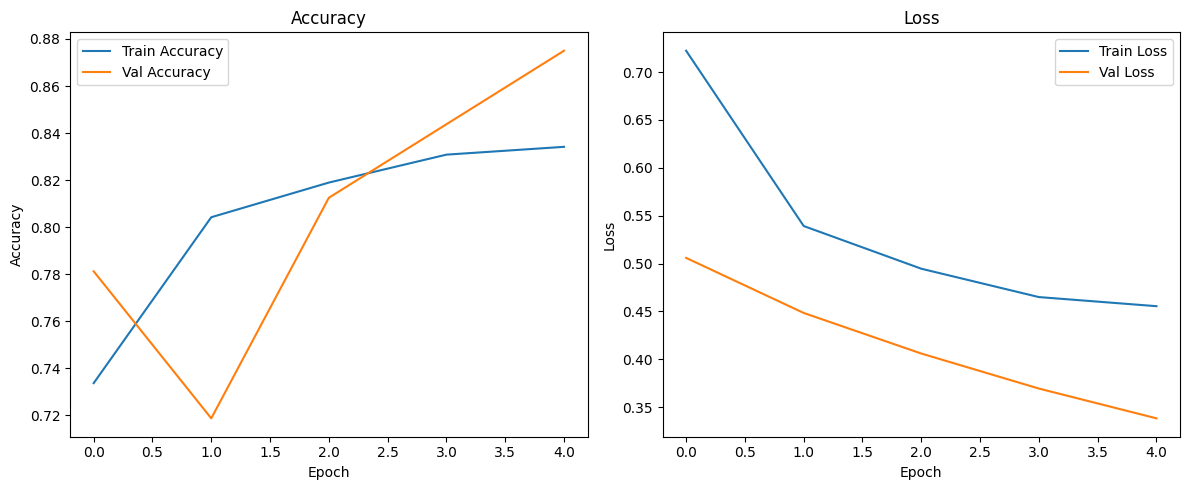

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path="/kaggle/input/kermany2018/OCT2017 /test/NORMAL/NORMAL-1017237-1.jpeg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

class_indices = test_image_gen.class_indices
class_labels = dict((v, k) for k, v in class_indices.items())

print("Predicted Class:", class_labels[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Predicted Class: NORMAL


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path="/kaggle/input/kermany2018/OCT2017 /test/DME/DME-1274315-1.jpeg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

class_indices = test_image_gen.class_indices
class_labels = dict((v, k) for k, v in class_indices.items())

print("Predicted Class:", class_labels[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Class: DME
